In [4]:
import os
import cv2
import math
import sys
import numpy as np # linear algebra
from PIL import Image
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from IPython.display import display, Math

In [1]:
!pip install --quiet qiskit

In [2]:
!pip install --quiet qiskit_aer

In [3]:
!pip install --quiet pylatexenc

In [32]:
!pip install --quiet tabulate


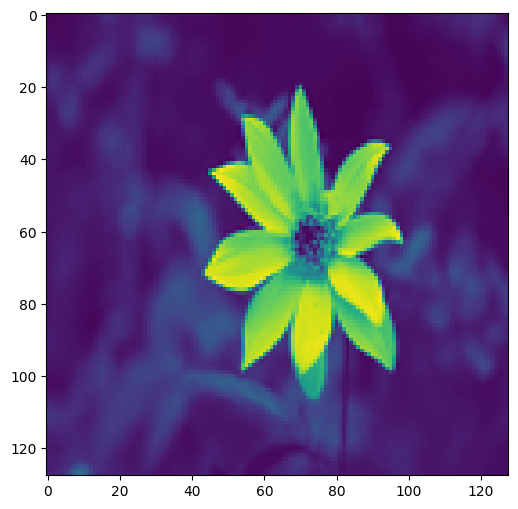

In [26]:
img = Image.open('/kaggle/input/flower-white/flower.png') 
img = img.convert('L') #image mode, in LA mode the image is converted to gray scale image
img = img.resize((128, 128))
plt.figure(figsize=(9, 6))
plt.imshow(img) 
plt.show()


In [27]:
img1=np.asarray(img)

def array_to_latex(array):
    """Convert a NumPy array to LaTeX tabular format."""
    # Start the LaTeX tabular environment
    latex_code = "\\begin{tabular}{|" + " | ".join(["c"] * array.shape[1]) + "|}\n"
    latex_code += "\\hline\n"  # Add horizontal line for the top of the table

    # Add the rows of the array to the LaTeX table
    for row in array:
        latex_code += " & ".join(f"{val:.2f}" for val in row) + " \\\\\n\\hline\n"

    latex_code += "\\end{tabular}"
    return latex_code

# Convert the array to LaTeX format
latex_output = array_to_latex(img1)

# Print the LaTeX output
#print(latex_output)

# Display the LaTeX output in the notebook
#display(Math(latex_output))

In [28]:

# Get the shape (size) of the image
width, height = img.size

w_bits = int(np.ceil(math.log(width,2)))
h_bits = int(np.ceil(math.log(height,2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

In [29]:
from qiskit import *
from qiskit_aer import  Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram

In [30]:
indx = QuantumRegister(w_bits+h_bits, 'indx')
intensity = QuantumRegister(8,'intensity')
cr = ClassicalRegister(len(indx)+len(intensity), 'cr')
qc_image = QuantumCircuit(intensity, indx, cr)
num_qubits = qc_image.num_qubits

In [31]:
# Transform image to numpy matrix
imgmat = np.array(list(img.getdata(band=0)), float)
imgmat.shape = (img.size[1], img.size[0])
imgmat = np.matrix(imgmat)

In [32]:
#SVD decomposition
U, sigma, V = np.linalg.svd(imgmat)

In [33]:
# Number of singular values
num_singular_values = len(U)
print(f'Number of singular values: {num_singular_values}')

Number of singular values: 128


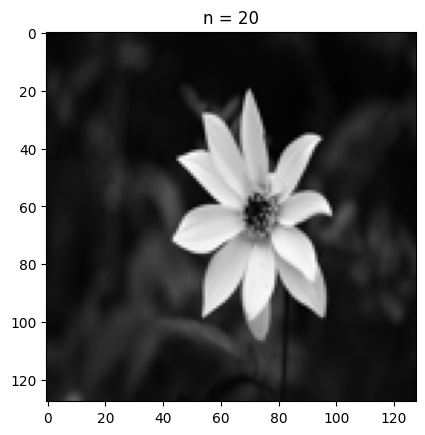

In [34]:

reconstimg = np.matrix(U[:, :128]) * np.diag(sigma[:128]) * np.matrix(V[:128, :])
plt.imshow(reconstimg, cmap='gray')
title = "n = %s" % 20
plt.title(title)
plt.show()

In [35]:
reconstimg.size

16384

In [36]:
#input_im = img.copy().flatten()

img_array=reconstimg
img_array = np.array(img_array).astype(int)

#Flatten the NumPy array
input_im = img_array.flatten()
#input_im.size

In [37]:
input_im

array([3, 5, 4, ..., 8, 9, 7])

In [38]:
qc_image.h(indx)
#qc_image.draw(output="mpl")

In [39]:
for i, pixel in enumerate(input_im):
    pixel_bin = "{0:b}".format(pixel).zfill(len(intensity))
    position = "{0:b}".format(i).zfill(len(indx))
    for j, coord in enumerate(position):
        if int(coord) and int(pixel_bin) != 0:
            qc_image.x(qc_image.num_qubits-j-1)
    for idx, px_value in enumerate(pixel_bin[::-1]):
        if(px_value=='1'):
            control_qubits = list(range(intensity.size, intensity.size + indx.size))
            target_qubit = intensity[idx]
            qc_image.mcx(control_qubits, target_qubit)
    if i!=len(input_im) - 1:
        for j, coord in enumerate(position):
            if int(coord) and int(pixel_bin) != 0:
                qc_image.x(qc_image.num_qubits-j-1)
    qc_image.barrier()
qc_image.measure(range(qc_image.num_qubits),range(cr.size))


In [63]:
#result = encode_image(qc_image, input_im, intensity, indx)
#qc_image.draw(output="mpl")

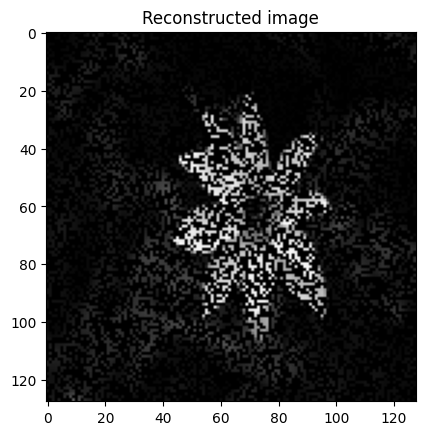

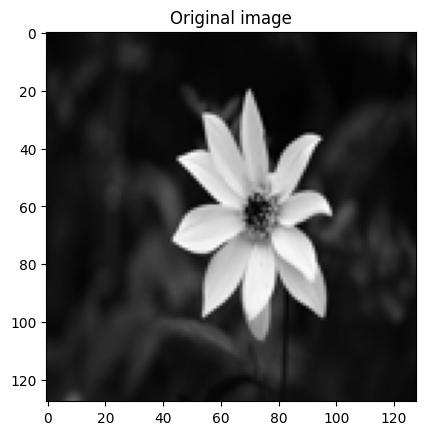

In [40]:
# Initialize the Aer simulator backend
aer_sim = Aer.get_backend('aer_simulator')
job_neqr = aer_sim.run(transpile(qc_image, aer_sim), shots=8192)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts(qc_image)
counts_neqr
out_pixels = []
for item in counts_neqr:
    out_pixels.append((int(item[0:w_bits+h_bits], 2), int(item[w_bits+h_bits:],2)))
out_image = np.zeros((1, len(input_im)))
for pixel in out_pixels:
    out_image[0][pixel[0]] = pixel[1]
out_image = np.reshape(out_image, (img.size))
plt.imshow(out_image, cmap='gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(img, cmap='gray')
plt.title('Original image')
plt.show()

# Quantum Circuit Information

In [20]:
# Get the number of gates (operations) in the circuit
gate_counts = qc_image.count_ops()
print("Gate counts:", gate_counts)

Gate counts: OrderedDict([('x', 10192), ('mcx', 3008), ('barrier', 1024), ('measure', 18), ('h', 10)])


In [21]:
# Get the depth of the circuit
circuit_depth = qc_image.depth()
print("Circuit depth:", circuit_depth)

Circuit depth: 5047


In [22]:
# Get the total number of operations (gates)
total_operations = qc_image.size()
print("Total number of operations:", total_operations)

Total number of operations: 13228


# Mean Square Error  Comparison

In [23]:
# Compute the Mean Squared Error (MSE)
mse_value = np.mean((img - out_image) ** 2)
mse_value

0.494140625

# PSNR Calculation

In [24]:
import numpy as np

def calculate_psnr(original_image, reconstructed_image):
    mse = np.mean((original_image - reconstructed_image) ** 2)
    if mse == 0:
        return float('inf')  # Means no difference between images
    max_pixel_value = 255.0
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    return psnr

psnr_value = calculate_psnr(img, out_image)
print(f"PSNR: {psnr_value} dB")

PSNR: 51.19229800667923 dB


In [25]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_ssim(original_image, reconstructed_image):
    """
    Calculate the Structural Similarity Index (SSIM) between two images.
    
    Parameters:
        original_image (ndarray): The original image.
        reconstructed_image (ndarray): The reconstructed image.

    Returns:
        float: SSIM value.
    """
    # Convert images to NumPy arrays if they are not already
    if not isinstance(original_image, np.ndarray):
        original_image = np.array(original_image)
    if not isinstance(reconstructed_image, np.ndarray):
        reconstructed_image = np.array(reconstructed_image)
    
    # Ensure the images have the same dimensions
    if original_image.shape != reconstructed_image.shape:
        raise ValueError("Original and reconstructed images must have the same dimensions.")
    
    ssim_value, _ = ssim(
        original_image, 
        reconstructed_image, 
        full=True, 
        data_range=original_image.max() - original_image.min()
    )
    return ssim_value

# Assuming `img` and `out_image` are the original and reconstructed images
ssim_value = calculate_ssim(img, out_image)
print(f"SSIM: {ssim_value}")


SSIM: 0.99937378453619
